### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

#BASIC 

In [ ]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx # Imp library for graph link feature engineering
import pdb
import pickle

In [ ]:
!wget --header="Host: doc-08-ao-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_os3ftn4tgjvd1o3qu47r0sa1m0inhkii=06611803433127174159|1650279900000|20s4t71aphpjcfu79o33cmo05bdrmvcr" --header="Connection: keep-alive" "https://doc-08-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/8fqplvgg7nbcett6i3musdlvfmo6ason/1650280050000/06629147635963609455/06611803433127174159/1l1adJnTgeHULVuoLdTRyqi25-z6shBSL?e=download&ax=ACxEAsZohDPQbHSpPn3sh8k-7KjSXqjR6YoaGefDI5fwMYQGw32U1nFyAbdaZ0lFPfOf8fiNLJUlMlvNLT28lnpwuO9EIkCSKJH7rf6QablXqZLCZi2mSCfbzizTMReXD_UHffMPt83Lf4w2hGlwb6V2G0MzO1nKR8S4Cpx3jFIQE61SqrN4K5tAzraRy7_dz_r-1GErl7MJBHjgMlupzf36F51kmUdedSyqcYeG3iUVqJt0GAzJ_d1k5sEL0dB4eidyzgTIa-Iam86F4RQcMDpeG5ZdV9oZ1kLDLT82x02iRRau59ihZKOPBV93MyAqQ0HBvw82XTOveNPxkHf_REJbCqovMJCPwexW6bNkTpiRV-QeQsIYKdUaxqFhLNN12cO8TaA52DgyfTvQjV5A0udJTk_9PC3LOxFIJTRF_xal7eD3LNPgz-xc_BkPjpA754xs5QsZHPhLL-Emuadah8uUprfWMgQx3UQWDHPo2qOKVoSUMQrA2oD29AII54sEkwtF-hlr5x__O4alCx-hZ3ewwv58_r-UgSLZvw8oCHX1t_cytpU1qdv7uwQjoqNcfSG69urOhKFS_2Wt-eXWEXC3uLCpjZjvhWAEZxq5R093o1ANDjH2yJMzOkcDHXAwr6bmCMFK7YfhVlXOb2UsP4IqlRFSG8i3oG4St56ugnn1JUF_ZVXplW0Jibyd0giodj3WRSRg-E2x6GrZfgVdMVPE1-xiBQznl6RXeGdNE1TU1nIdRh037Lc&authuser=0" -c -O 'train.csv'

--2022-04-18 11:07:59--  https://doc-08-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/8fqplvgg7nbcett6i3musdlvfmo6ason/1650280050000/06629147635963609455/06611803433127174159/1l1adJnTgeHULVuoLdTRyqi25-z6shBSL?e=download&ax=ACxEAsZohDPQbHSpPn3sh8k-7KjSXqjR6YoaGefDI5fwMYQGw32U1nFyAbdaZ0lFPfOf8fiNLJUlMlvNLT28lnpwuO9EIkCSKJH7rf6QablXqZLCZi2mSCfbzizTMReXD_UHffMPt83Lf4w2hGlwb6V2G0MzO1nKR8S4Cpx3jFIQE61SqrN4K5tAzraRy7_dz_r-1GErl7MJBHjgMlupzf36F51kmUdedSyqcYeG3iUVqJt0GAzJ_d1k5sEL0dB4eidyzgTIa-Iam86F4RQcMDpeG5ZdV9oZ1kLDLT82x02iRRau59ihZKOPBV93MyAqQ0HBvw82XTOveNPxkHf_REJbCqovMJCPwexW6bNkTpiRV-QeQsIYKdUaxqFhLNN12cO8TaA52DgyfTvQjV5A0udJTk_9PC3LOxFIJTRF_xal7eD3LNPgz-xc_BkPjpA754xs5QsZHPhLL-Emuadah8uUprfWMgQx3UQWDHPo2qOKVoSUMQrA2oD29AII54sEkwtF-hlr5x__O4alCx-hZ3ewwv58_r-UgSLZvw8oCHX1t_cytpU1qdv7uwQjoqNcfSG69urOhKFS_2Wt-eXWEXC3uLCpjZjvhWAEZxq5R093o1ANDjH2yJMzOkcDHXAwr6bmCMFK7YfhVlXOb2UsP4IqlRFSG8i3oG4St56ugnn1JUF_ZVXplW0Jibyd0giodj3WRSRg-E2x6GrZfgVdMVPE1-xiBQznl6RXeGdNE1

In [ ]:
!wget --header="Host: doc-0s-ao-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_os3ftn4tgjvd1o3qu47r0sa1m0inhkii=06611803433127174159|1650279900000|20s4t71aphpjcfu79o33cmo05bdrmvcr" --header="Connection: keep-alive" "https://doc-0s-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/ad59jufkcnggv5ford3ibhjq8r3iqm3b/1650280050000/06629147635963609455/06611803433127174159/1c5omWa9D1b4iQ28tiDfMs4wglhKKLA9X?e=download&ax=ACxEAsZBBZ2k-UknypcP5UsdT28KyRkoQSUWJkF2DBwX1HbkKDwuwkLQZmGsArAaIcwv6muJuxbU9WXxH3kXpQVTckR7t9a24P2UnShQP4o6L3mJImjhRj7rIZ35vgvQ_2liD-16lryd5nhjIj91jd2ahTLhpbIiukCOsQzDI4Oyyix54cLUcmEcHH4pbPsta9lTHCAJaHd1DTTpeHjHLKPxwaJzpopaYozkNJ4wbkxC3RjNgNkBiqysEvds3qaIGlOohbKF_GBQ_msRMnZPfckfub9t6QSVJ-2zsCDghPB6a8fz9B1IC33E2_LUkHIivNnlC_hkGUBhByOIM9GdIhWURUgKJ3plVNc07WytNB-47JPZxN2Qdf8W7nmwf9O_2b3S6nPDffyb6upkYCYnBdbQqtWKohoQ-g4GEgWdIwNAwMHvpTNONSjLXvII13le8W1AhqVXvdA3ACQN7Migu1huO7uvQOtFuxupsLzW2XdQOuVJJ1FTVgs9AiNwL06SQABanxVBdaKaNoamQOhZ80HaOBYPwzUIgkpV4tkF-oppKI3dzhk2i9jw5UBKbdy3b2smC3xwDHCQxd5SIDPs3uJfjmwmQH8guUrhk2r9YOC0WuLmMlxi1oVLTej0WXvNtSP6a1qxvcaFAlL9_GMkSXKKfYNavl9NsZ6elqjiDX1u8_L3bgAXDGO4yU-Lgq035gmE1jhZo5Rjx0c6t0rY_UZAhmsff3Le0MzlS8Buqyh7FIA4JNKO-A0&authuser=0" -c -O 'train_woheader.csv'

--2022-04-18 11:08:52--  https://doc-0s-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/ad59jufkcnggv5ford3ibhjq8r3iqm3b/1650280050000/06629147635963609455/06611803433127174159/1c5omWa9D1b4iQ28tiDfMs4wglhKKLA9X?e=download&ax=ACxEAsZBBZ2k-UknypcP5UsdT28KyRkoQSUWJkF2DBwX1HbkKDwuwkLQZmGsArAaIcwv6muJuxbU9WXxH3kXpQVTckR7t9a24P2UnShQP4o6L3mJImjhRj7rIZ35vgvQ_2liD-16lryd5nhjIj91jd2ahTLhpbIiukCOsQzDI4Oyyix54cLUcmEcHH4pbPsta9lTHCAJaHd1DTTpeHjHLKPxwaJzpopaYozkNJ4wbkxC3RjNgNkBiqysEvds3qaIGlOohbKF_GBQ_msRMnZPfckfub9t6QSVJ-2zsCDghPB6a8fz9B1IC33E2_LUkHIivNnlC_hkGUBhByOIM9GdIhWURUgKJ3plVNc07WytNB-47JPZxN2Qdf8W7nmwf9O_2b3S6nPDffyb6upkYCYnBdbQqtWKohoQ-g4GEgWdIwNAwMHvpTNONSjLXvII13le8W1AhqVXvdA3ACQN7Migu1huO7uvQOtFuxupsLzW2XdQOuVJJ1FTVgs9AiNwL06SQABanxVBdaKaNoamQOhZ80HaOBYPwzUIgkpV4tkF-oppKI3dzhk2i9jw5UBKbdy3b2smC3xwDHCQxd5SIDPs3uJfjmwmQH8guUrhk2r9YOC0WuLmMlxi1oVLTej0WXvNtSP6a1qxvcaFAlL9_GMkSXKKfYNavl9NsZ6elqjiDX1u8_L3bgAXDGO4yU-Lgq035gmE1jhZo5Rjx0c6t0rY_UZAhmsff3Le0MzlS8Buqy

In [ ]:
#reading graph
if not os.path.isfile('train_woheader.csv'):
    traincsv = pd.read_csv('train.csv') # We will need this file
    print(traincsv[traincsv.isna().any(1)]) #https://stackoverflow.com/questions/54158555/what-is-the-difference-between-any-and-any1
    print(traincsv.info()) #Gives info of columns same as pandas df.info()
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('train_woheader.csv',header=False,index=False) # Need this file too
    print("saved the graph into file")
else:
    g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int) #
    print(nx.info(g))

DiGraph with 1862220 nodes and 9437519 edges


Display subgraph

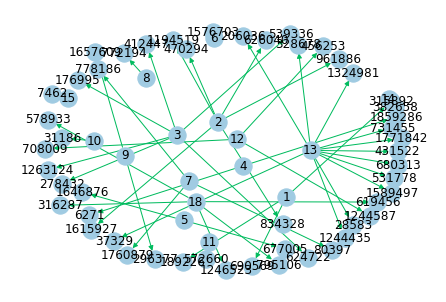

In [ ]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False) # Here we created a train.csv file with no headers
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
#print(nx.info(subgraph)

#EDA 

In [ ]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes())) #g.nodes

The number of unique persons 1862220


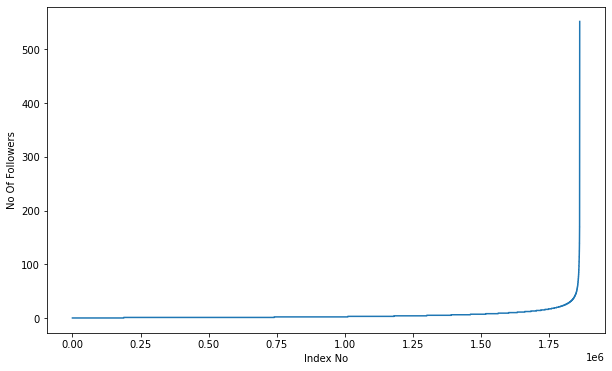

In [ ]:
#In Degree- Followers

indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

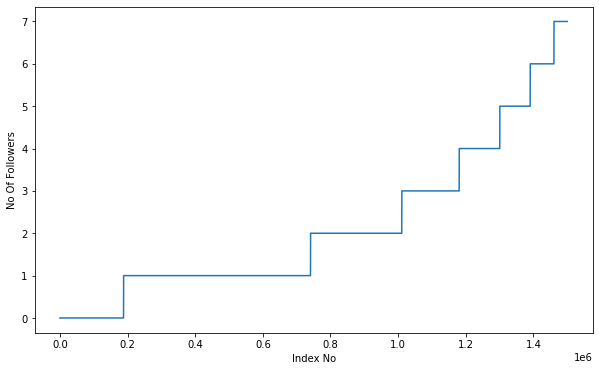

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

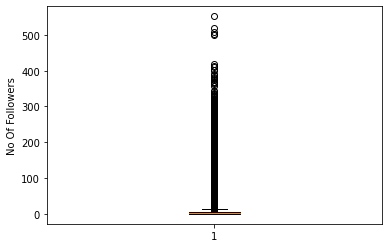

In [ ]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


In [ ]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


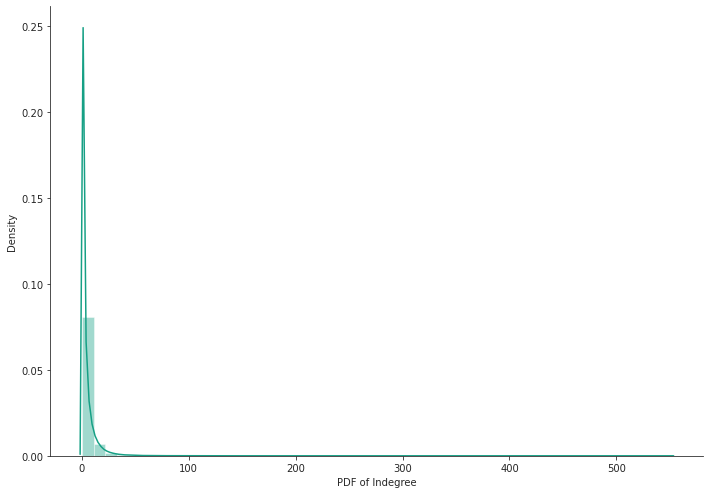

In [ ]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist[0:10000000], color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

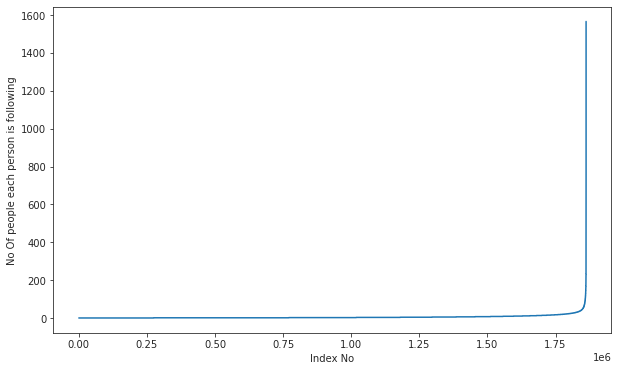

In [ ]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

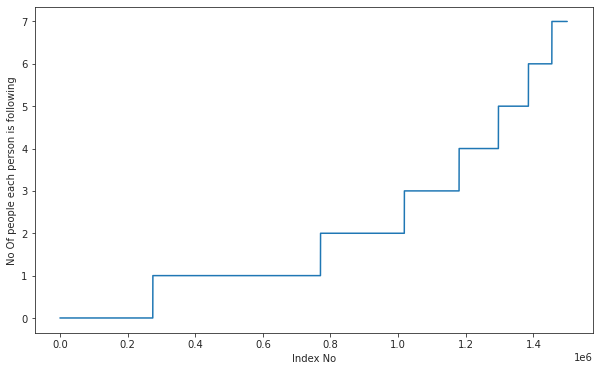

In [ ]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [ ]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


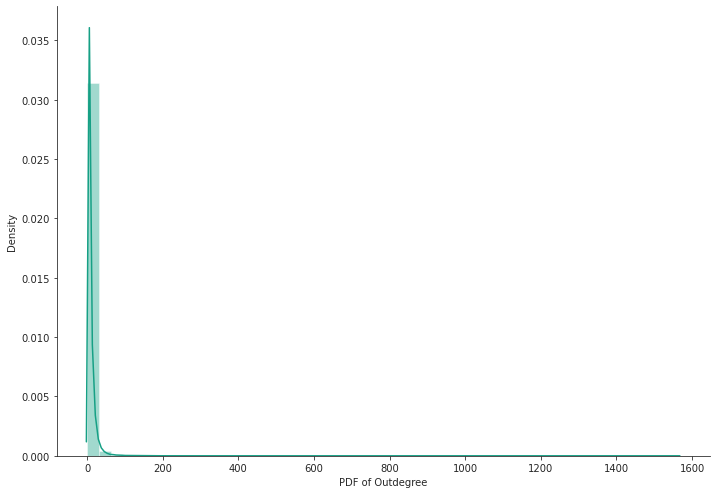

In [ ]:
sns.set_style('ticks')#https://seaborn.pydata.org/generated/seaborn.distplot.html
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

After performing some basic EDA on the indegree and outdegree features we can conclude-

1. Simple plot with indeg/outdeg on x and index no on y we are finding max indices with almost no followers ie wrong interpretation
2. When we try to focus on certain points ie 1500000 we are able to identify the square type pattern
3. When we try the percentiles we get a threshold value for followers and followees
4. Finally box plot and the sns.displot we cannot incur a proper distribution of the feature.

In [ ]:
print('No of persons those with no followees anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those with no followees anyone are 274512 and % is 14.741115442858524


In [ ]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [ ]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


In [ ]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

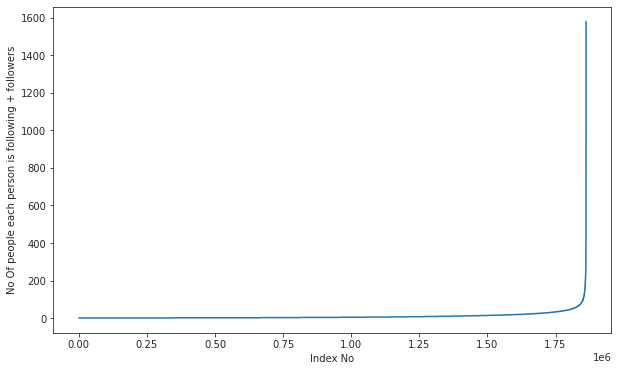

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

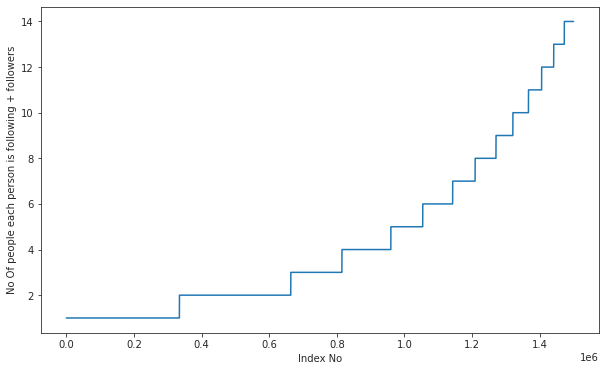

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [ ]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [ ]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [ ]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [ ]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [ ]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


In [ ]:
!wget --header="Host: doc-04-ao-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_os3ftn4tgjvd1o3qu47r0sa1m0inhkii_nonce=bv03l4pmjio9e" --header="Connection: keep-alive" "https://doc-04-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/bl7m1t6f3hi0nmafn6h0u7cbjbcg71sh/1650279900000/06629147635963609455/06611803433127174159/1XNxqMI6qyXYhi2XVVRIxqD11hKgh2oja?e=download&ax=ACxEAsYgnvQEILV-YTlfjJYFQfoIa2QGq2I9F8wvYUzIuZ1q-AWO69xaf_FDstwTRpytKxRsp_rnf31Exo8iCjlWxiRMX96mGRW4PgzCMkfJRR4nkYz1ub606_r37YXvQST1Re4_2L-y2tPO_aulCmxU9FCT78UDUVKWw0nIjqv5Bpr_0Eark6Z4v-1Jl-9fYio10_GeFdek91j0gHCVpyfZmBah4XkOgta_02-KSUhfB01fI6Vtl_wyRcoMzSwlSZ14zBMYQ_vFSSCjy8NERGDty1Xv0A6g_XaiTaJA6sIbJIHuseullWF5k9vW9YiYfe_vgck8x8ySwWyAt9VmGvlzrdbLEEWfQt-AeyRIwdNqZQMC7UYGOXihw-dn7CVicQ7THkrm_KLNJf37GFVKuzuK48jMY3zAANExt-eEoTKebhE1kAEYsELt3HQljcrQoFEu-xn15uBaGmYmgCxwbQ26Cipk-K1oM0aupNhiakJJ7jnTgoYlyVereH5N3UfE9KzztirXGfcm0dPMgVDXb-3txEf2pSva6suFa0pIqhUCEuvqZ4Ku-6mQZ9MW5ayycwnHdOyiq_lA7reEHhZVo8wOeT2AnT5JvRQD3ge0RgD2-kCVKnWLtAkYD09bhZ1DkN-nXcYUWf3mvS4Y4uS9zMYGJBSro-kdX7xHE4IcTSp1MmZcYGDtlVXBLg70IWYFgb67vklF2OgZ_ntAlh-L_dswv3h14XMXKH5c5rFCQDmHiQWzkhb0JFA&authuser=0&nonce=bv03l4pmjio9e&user=06611803433127174159&hash=i5rpd3ftljef0dg6mkvvumo7mta40mu6" -c -O 'missing_edges_final.p'

--2022-04-18 11:06:22--  https://doc-04-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/bl7m1t6f3hi0nmafn6h0u7cbjbcg71sh/1650279900000/06629147635963609455/06611803433127174159/1XNxqMI6qyXYhi2XVVRIxqD11hKgh2oja?e=download&ax=ACxEAsYgnvQEILV-YTlfjJYFQfoIa2QGq2I9F8wvYUzIuZ1q-AWO69xaf_FDstwTRpytKxRsp_rnf31Exo8iCjlWxiRMX96mGRW4PgzCMkfJRR4nkYz1ub606_r37YXvQST1Re4_2L-y2tPO_aulCmxU9FCT78UDUVKWw0nIjqv5Bpr_0Eark6Z4v-1Jl-9fYio10_GeFdek91j0gHCVpyfZmBah4XkOgta_02-KSUhfB01fI6Vtl_wyRcoMzSwlSZ14zBMYQ_vFSSCjy8NERGDty1Xv0A6g_XaiTaJA6sIbJIHuseullWF5k9vW9YiYfe_vgck8x8ySwWyAt9VmGvlzrdbLEEWfQt-AeyRIwdNqZQMC7UYGOXihw-dn7CVicQ7THkrm_KLNJf37GFVKuzuK48jMY3zAANExt-eEoTKebhE1kAEYsELt3HQljcrQoFEu-xn15uBaGmYmgCxwbQ26Cipk-K1oM0aupNhiakJJ7jnTgoYlyVereH5N3UfE9KzztirXGfcm0dPMgVDXb-3txEf2pSva6suFa0pIqhUCEuvqZ4Ku-6mQZ9MW5ayycwnHdOyiq_lA7reEHhZVo8wOeT2AnT5JvRQD3ge0RgD2-kCVKnWLtAkYD09bhZ1DkN-nXcYUWf3mvS4Y4uS9zMYGJBSro-kdX7xHE4IcTSp1MmZcYGDtlVXBLg70IWYFgb67vklF2OgZ_ntAlh-L_dswv3h14XMXKH5c5rFCQD

In [ ]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges = dict() #
    for edge in r: #
        edges[(edge[0], edge[1])] = 1 #
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('missing_edges_final.p','rb'))

CPU times: user 2.04 s, sys: 1.7 s, total: 3.74 s
Wall time: 3.66 s


In [ ]:
!wget --header="Host: doc-00-ao-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_os3ftn4tgjvd1o3qu47r0sa1m0inhkii_nonce=eevkjdguht17g" --header="Connection: keep-alive" "https://doc-00-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/bh7g3m6hu6q3t5fsndr7um7tcj5oqojm/1650281850000/06629147635963609455/06611803433127174159/1XLHsIRXKLx9TA9nuC1SS7JDkLyRVmo69?e=download&ax=ACxEAsbh7QxWYLqr9kTXyKyem_Bf9YTIwJCPKAa0Q8H-iXtmy93ilhqejECSPEGcdeLCiLqhPh2jcXtM5WVeOge_Raf2H_ipVOR71ykP8bHTy7udkETSKbxNiyHVNT51jb2jxzq4x4vYFMtnoC1OwXmZ68_xAtVjfD5ecg7ngq7c4Lh0mqhzZBqfH8sbnYkwgpJbrCSYlBz1KghYggn4k3GJr3n5DEOzA13vb-QqYENhmKcOxbtzLPE4yvYMLOn9PSsmoRHFSl8qYv8rCmcf_23Uf1Rir30Xjm5U39jYW-BHxr9TVfoCj0gwCrJAolpJ_VR14rzkgkDFxekQy7Zg_YTaxRAtBwfLNGEiaLtFYEU6AC7IKshq7fgPHPgeqagdLsrF5qfpG6rjvIip9ejHBKiL07ELozO_WYh7xNPAGGLQ3VEXj0AIMFtJHthaV9Qyp4iD1AGDzvsH2EyMrA898rk0WlVO3GcSGXTrPBE0j19v52sKnlfvVgs93UGI3OquXZGhvXrDDvqxSR1aH8aab4CAx_tKK1QpBKj2mI51xDCUSjsufzGW-yojTnUqp014gkDUNWorGpS3aBGy2R7NNLNCrlVpsFm_eTqsiMilWxFSv8adg3CBxGSPtGKodmlruHwCfmcmhGA13AENZd4H3Jy7rOpjue44Th9CRxqxJEeEMYBZu2eWZXX98zpOS_1tTXr9ftxQcoJNLxLwerOlLijpYk4iZcOHr7ri6nZFn3tcOUl5puTks6w&authuser=0&nonce=eevkjdguht17g&user=06611803433127174159&hash=oev85debvd0pm31v5c2u021p7tck03fl" -c -O 'train_pos_after_eda.csv'

--2022-04-18 11:38:56--  https://doc-00-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/bh7g3m6hu6q3t5fsndr7um7tcj5oqojm/1650281850000/06629147635963609455/06611803433127174159/1XLHsIRXKLx9TA9nuC1SS7JDkLyRVmo69?e=download&ax=ACxEAsbh7QxWYLqr9kTXyKyem_Bf9YTIwJCPKAa0Q8H-iXtmy93ilhqejECSPEGcdeLCiLqhPh2jcXtM5WVeOge_Raf2H_ipVOR71ykP8bHTy7udkETSKbxNiyHVNT51jb2jxzq4x4vYFMtnoC1OwXmZ68_xAtVjfD5ecg7ngq7c4Lh0mqhzZBqfH8sbnYkwgpJbrCSYlBz1KghYggn4k3GJr3n5DEOzA13vb-QqYENhmKcOxbtzLPE4yvYMLOn9PSsmoRHFSl8qYv8rCmcf_23Uf1Rir30Xjm5U39jYW-BHxr9TVfoCj0gwCrJAolpJ_VR14rzkgkDFxekQy7Zg_YTaxRAtBwfLNGEiaLtFYEU6AC7IKshq7fgPHPgeqagdLsrF5qfpG6rjvIip9ejHBKiL07ELozO_WYh7xNPAGGLQ3VEXj0AIMFtJHthaV9Qyp4iD1AGDzvsH2EyMrA898rk0WlVO3GcSGXTrPBE0j19v52sKnlfvVgs93UGI3OquXZGhvXrDDvqxSR1aH8aab4CAx_tKK1QpBKj2mI51xDCUSjsufzGW-yojTnUqp014gkDUNWorGpS3aBGy2R7NNLNCrlVpsFm_eTqsiMilWxFSv8adg3CBxGSPtGKodmlruHwCfmcmhGA13AENZd4H3Jy7rOpjue44Th9CRxqxJEeEMYBZu2eWZXX98zpOS_1tTXr9ftxQcoJNLxLwerOlLijpYk4iZcOHr7ri6nZFn3

In [ ]:
!wget --header="Host: doc-08-ao-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_os3ftn4tgjvd1o3qu47r0sa1m0inhkii=06611803433127174159|1650281850000|5m672m4fq68pgpiuq47vrpdi1ck559b7" --header="Connection: keep-alive" "https://doc-08-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/bmno3pnb3kv41up3t8sp8411p8b4pula/1650281925000/06629147635963609455/06611803433127174159/1qNhcor22jE5gJ_NfKATx_18oKYOKPy7_?e=download&ax=ACxEAsYwkUGZ2ORb1A0jRU110G6KS34KOHjk4cOXrTmR3C4-Fn9yHSMDPKf0OGzByqsTYhEkVv3AC6iQK6k-0c3MrGzsBXk8cSIgEv_KOXUF9yAsz5ZEA9130iT5NfaQh__tPN6a0D82WBtzdDXpY97UmNcxbOwgg27z4OPcp6dKW1FX7mkE_oiNfoVcKK4MOGRJKZ2wtQpzgVilOYWHvqBPAoo_XivG3n4r40ZnZWnh8jKhNpnx33IZWW-CtTY8cyshh0M-AX3-lY45yJ6EuLuZsJXZNyhPlgrZHk19-kbG-Y14JjZ0jMx9PIprP8NNhhSSCrKcFEylw0-AOfLuDRswmJdH1RnW88qBqb8HJK1x1pFxHv0CQ3pcWR1hLXW_7JfnAYGUwyJaUXknIrrhKfN3EfVjG_yfkqilxVTkOti-VOhN4vkFEx7RXFpR5UJAf39nfbtOf0xTwMK7aVrDKpWT8mfV1fBZaPgS6uLYVDwYTRvlQWr48FG3BNPkFDcbeuzjdVD-lc4zJvcNml9xszyW5NS7lleS6ISP1Ud0vLdrtevB2PTABZ0GxrkOkCEbQjXG8jZSgzfeXbR8IRy684Iet0ox7c7YpuajgphdYvI50cqYwa5GuuD1yCOCg-n-Mxj_zP2dCAApj6HHCm5LhyTSvMm-TkrRoaMYkCe4VxFHZKFXGEd_QtNrg8ythxid4EZOGzT7cZhS6okuapbQqSdqts2GcYRWwU4FstnxF9dXmdXF4gNqTn8&authuser=0" -c -O 'train_neg_after_eda.csv'

--2022-04-18 11:39:31--  https://doc-08-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/bmno3pnb3kv41up3t8sp8411p8b4pula/1650281925000/06629147635963609455/06611803433127174159/1qNhcor22jE5gJ_NfKATx_18oKYOKPy7_?e=download&ax=ACxEAsYwkUGZ2ORb1A0jRU110G6KS34KOHjk4cOXrTmR3C4-Fn9yHSMDPKf0OGzByqsTYhEkVv3AC6iQK6k-0c3MrGzsBXk8cSIgEv_KOXUF9yAsz5ZEA9130iT5NfaQh__tPN6a0D82WBtzdDXpY97UmNcxbOwgg27z4OPcp6dKW1FX7mkE_oiNfoVcKK4MOGRJKZ2wtQpzgVilOYWHvqBPAoo_XivG3n4r40ZnZWnh8jKhNpnx33IZWW-CtTY8cyshh0M-AX3-lY45yJ6EuLuZsJXZNyhPlgrZHk19-kbG-Y14JjZ0jMx9PIprP8NNhhSSCrKcFEylw0-AOfLuDRswmJdH1RnW88qBqb8HJK1x1pFxHv0CQ3pcWR1hLXW_7JfnAYGUwyJaUXknIrrhKfN3EfVjG_yfkqilxVTkOti-VOhN4vkFEx7RXFpR5UJAf39nfbtOf0xTwMK7aVrDKpWT8mfV1fBZaPgS6uLYVDwYTRvlQWr48FG3BNPkFDcbeuzjdVD-lc4zJvcNml9xszyW5NS7lleS6ISP1Ud0vLdrtevB2PTABZ0GxrkOkCEbQjXG8jZSgzfeXbR8IRy684Iet0ox7c7YpuajgphdYvI50cqYwa5GuuD1yCOCg-n-Mxj_zP2dCAApj6HHCm5LhyTSvMm-TkrRoaMYkCe4VxFHZKFXGEd_QtNrg8ythxid4EZOGzT7cZhS6okuapbQqSdqts2GcYRWwU4FstnxF9

In [ ]:
!wget --header="Host: doc-10-ao-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_os3ftn4tgjvd1o3qu47r0sa1m0inhkii=06611803433127174159|1650281850000|5m672m4fq68pgpiuq47vrpdi1ck559b7" --header="Connection: keep-alive" "https://doc-10-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/43jlmjebjv0m8nbbbnodgto2iq5qk7qn/1650281925000/06629147635963609455/06611803433127174159/1yldY87HoO-XyfCJqyFqyi7QKeJkhMXgB?e=download&ax=ACxEAsY_fHDUW1Zv9Py9POn-Bjevb5d9uJuBIFTA-SrM9AcwGejceJ93a701XmEulRxVQs0D7jcRh6cVfTsVxFtV6o3nk9-18yMZmJfmlNMlFl4khw6liF_NcDntyfc54uu7hLJoMLj9WRvgaJLVuZbuv1t3dXdsrhaPjmEQbI1EL7jVDHQ8rcFRgz8uyERq4yAQgFlgFyLzGYSWtSybDqcDV93KLpuwYcSvLYYc7FO7oVKU_1vbtSCdMELZFR-fvfCxEbh0WHiYj5358lUY4--NnTV2PmFzFFd3qOZAYFAVeFhNpWiQ7VexJg9BYBVBPBhCU3qOXEqer55-FRGZiml8jIgnPYHZPqix1yAQ1UzWPkJoQUWTz3gJhIOAFurz9hp9eX9QWzJ4vy6MQ8-N0U10nz_6Ls1_b5jz_NMR6WeUVmuw-QJVBKN6FoSVmZH-wNFLfXMTYNzxye7EZ_xZp1Shqs5VCh6iW9aRWi-PcPaOJpNixjYkrNv1qilEStDSSV4uA5vwKMU58SgakemeGk7MKI8wkiZkPf_Vg_2DRmS5lEyYZb-xtCueXakKjj7pVfhiz31RY_ZzN5waMJt8l0amZCFXVBwQ3utnSjqeiRE4oWZlab1wDjhAJZiA8VMdvvUbLKtT554G8Rz0m0Jg4_05JF0H-kx5kwf_R7caD-X4D6yVSb0Of7k78mtizRI3v3ojBlLlbUrEKvJ3WbIH_HPSd_2yumoSyttP2B1Y0Yk-5ZZKn67Veq0&authuser=0" -c -O 'test_pos_after_eda.csv'

--2022-04-18 11:40:00--  https://doc-10-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/43jlmjebjv0m8nbbbnodgto2iq5qk7qn/1650281925000/06629147635963609455/06611803433127174159/1yldY87HoO-XyfCJqyFqyi7QKeJkhMXgB?e=download&ax=ACxEAsY_fHDUW1Zv9Py9POn-Bjevb5d9uJuBIFTA-SrM9AcwGejceJ93a701XmEulRxVQs0D7jcRh6cVfTsVxFtV6o3nk9-18yMZmJfmlNMlFl4khw6liF_NcDntyfc54uu7hLJoMLj9WRvgaJLVuZbuv1t3dXdsrhaPjmEQbI1EL7jVDHQ8rcFRgz8uyERq4yAQgFlgFyLzGYSWtSybDqcDV93KLpuwYcSvLYYc7FO7oVKU_1vbtSCdMELZFR-fvfCxEbh0WHiYj5358lUY4--NnTV2PmFzFFd3qOZAYFAVeFhNpWiQ7VexJg9BYBVBPBhCU3qOXEqer55-FRGZiml8jIgnPYHZPqix1yAQ1UzWPkJoQUWTz3gJhIOAFurz9hp9eX9QWzJ4vy6MQ8-N0U10nz_6Ls1_b5jz_NMR6WeUVmuw-QJVBKN6FoSVmZH-wNFLfXMTYNzxye7EZ_xZp1Shqs5VCh6iW9aRWi-PcPaOJpNixjYkrNv1qilEStDSSV4uA5vwKMU58SgakemeGk7MKI8wkiZkPf_Vg_2DRmS5lEyYZb-xtCueXakKjj7pVfhiz31RY_ZzN5waMJt8l0amZCFXVBwQ3utnSjqeiRE4oWZlab1wDjhAJZiA8VMdvvUbLKtT554G8Rz0m0Jg4_05JF0H-kx5kwf_R7caD-X4D6yVSb0Of7k78mtizRI3v3ojBlLlbUrEKvJ3WbIH_HPSd_2yumoSyttP2B1Y0Y

In [ ]:
!wget --header="Host: doc-14-ao-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_os3ftn4tgjvd1o3qu47r0sa1m0inhkii=06611803433127174159|1650281850000|5m672m4fq68pgpiuq47vrpdi1ck559b7" --header="Connection: keep-alive" "https://doc-14-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/l442svved9182247ef5ho6j0qr92belh/1650282000000/06629147635963609455/06611803433127174159/1yynFkCz80RcbTgPylw8cdZ37qEsfxmGV?e=download&ax=ACxEAsbve8PqslJjkICLVdtp-tGYExf6yhvLpHLHPiJu_9PZ3mAwRZbk_NC4PGm2FNl_RJELudCN4BhWVRsnTB5LkZkYGJV3ze180YORdPs-R2M-V9IyBq_kVlELg9S_YBWdH7_K68zYbdPd17p-QDE3i-jc-Vb2rNjZflWIeHYlkRvC53GOCtHX0VQAHEOBa25yxKdehZT94a2Uskiz8ic6bXrekxvzCDtPKelhVpFL4wPsdTTD5m1IRWfcSUEUNUIzvlHejiJB-By1YlLT1ctQd3nquge5sE45qX0GzmyAIcfC5_oZAeOTIhR7IK8MUDVLzLHaaX-f5MjZi2ke6APxJqLG6m1kKUY6RsXhOHjNUKKdirf3Pgv3eyG7WhKkyXyHavwmsIEJT7a7ahzdx5J2sHx03sJr3e3U2RUbsO7z-ftRJLGKz6EyAkMlzfFEZse5iJOxcMUxXrzwDez7JsokBexWP_-Ix869NLXeeFnsoznSPr2VMi5NRPFCNG-e-WNURHlzqlkvvKb6tavOisBXKFDeP_YzHi-zWBKfBSrsxQi73fa_YcN2sonOM4GDOwqddjq9_53i1jJYGrld_8q2BfXIuV_WY9mycjgMH9q2ealj3xgmosXzT7dkAfm-PmNgk9e3SzXdeAkgk2TLz2TzSavjuTsYODPQnbNXE5dpwyFZKi4nxBSYJ2kohpRXnq8mI1hDP85jDGTp3MPnA9qLjFDmAwLq_oIawytEeY9TnfuXeG1J32E&authuser=0" -c -O 'test_neg_after_eda.csv'

--2022-04-18 11:40:36--  https://doc-14-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/l442svved9182247ef5ho6j0qr92belh/1650282000000/06629147635963609455/06611803433127174159/1yynFkCz80RcbTgPylw8cdZ37qEsfxmGV?e=download&ax=ACxEAsbve8PqslJjkICLVdtp-tGYExf6yhvLpHLHPiJu_9PZ3mAwRZbk_NC4PGm2FNl_RJELudCN4BhWVRsnTB5LkZkYGJV3ze180YORdPs-R2M-V9IyBq_kVlELg9S_YBWdH7_K68zYbdPd17p-QDE3i-jc-Vb2rNjZflWIeHYlkRvC53GOCtHX0VQAHEOBa25yxKdehZT94a2Uskiz8ic6bXrekxvzCDtPKelhVpFL4wPsdTTD5m1IRWfcSUEUNUIzvlHejiJB-By1YlLT1ctQd3nquge5sE45qX0GzmyAIcfC5_oZAeOTIhR7IK8MUDVLzLHaaX-f5MjZi2ke6APxJqLG6m1kKUY6RsXhOHjNUKKdirf3Pgv3eyG7WhKkyXyHavwmsIEJT7a7ahzdx5J2sHx03sJr3e3U2RUbsO7z-ftRJLGKz6EyAkMlzfFEZse5iJOxcMUxXrzwDez7JsokBexWP_-Ix869NLXeeFnsoznSPr2VMi5NRPFCNG-e-WNURHlzqlkvvKb6tavOisBXKFDeP_YzHi-zWBKfBSrsxQi73fa_YcN2sonOM4GDOwqddjq9_53i1jJYGrld_8q2BfXIuV_WY9mycjgMH9q2ealj3xgmosXzT7dkAfm-PmNgk9e3SzXdeAkgk2TLz2TzSavjuTsYODPQnbNXE5dpwyFZKi4nxBSYJ2kohpRXnq8mI1hDP85jDGTp3MPnA9qLjFDmAwLq_oIawytEeY

In [ ]:
!wget --header="Host: doc-04-ao-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_os3ftn4tgjvd1o3qu47r0sa1m0inhkii=06611803433127174159|1650281850000|5m672m4fq68pgpiuq47vrpdi1ck559b7" --header="Connection: keep-alive" "https://doc-04-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/ogg5crak2bji5gqcn5ik380oj47ufssk/1650282000000/06629147635963609455/06611803433127174159/1_KN7S8zfHdrkRjRYOEtBxBVq8JrGxPXD?e=download&ax=ACxEAsZjjdKhxaacpGrOSTuL23PEwtaUpp9jZZHSOrBtx4fIIo4UPHxIj2NvCcIHSEBZEy2LCrqObcKDeHnBgQKiUgTOVWAKDWQpPbY5IpWzvham3YgNTU_nT99RFzkfDiQHkRSXU5XX72VrrenylUrkKo6IH_Wd84ZWcGt3lc98nf_dM8bjCOxfV_CBc26h-4BMQBma4B5QzJPfBaw3fjuijHVEEsiDe9ScpAm0B420kOSSrDItx09-VB-9NRmdDvhDI_94kxXoKJjaNV-BilYNA9AVyGZMv-tY1EKx8RUMOsbOg2qRZJSvL_vBjgTmS4CaXkdTy3wXUp8aUhUIgBVX2DteNCyuqW9EacQt80sHjG_lmKR1GGpc02S8Y9EoIb_q0yLO_Y1tpWcI5QkI4JKwIH1BlkW3h5eYkU2QBghw228HlduyX-XA-40Evf-AYlHHNFB5ypWzjB6Y1k3XownOeonOYV3HItrJQoDDxYNthIR36AtpzkG3MCK5dJNDoS9yFbAJBFE9aV5Fpvajb_7Mmoc5kZHnUCPjd6wyK3AD5xULOnQ78WV1q9vTyt2RTvdRlsouZ7Pl-AK6PwGdfNLv2CBvHJkGfukl29LYt8uSl7xEz87PFVWmZo4WGvpH0HRPv5WNYkBeAq7xu4t9POXOvP_vi4GG7qeLgo5IXBnRhfZg9hV2Cyk1b-DGBvx3cjEjScGYBXbHk4Q7FrUStwiPdd7vTruL2oeQjOkz8fCjXRlH0zXq_SM&authuser=0" -c -O 'test_after_eda.csv'

--2022-04-18 11:41:29--  https://doc-04-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/ogg5crak2bji5gqcn5ik380oj47ufssk/1650282000000/06629147635963609455/06611803433127174159/1_KN7S8zfHdrkRjRYOEtBxBVq8JrGxPXD?e=download&ax=ACxEAsZjjdKhxaacpGrOSTuL23PEwtaUpp9jZZHSOrBtx4fIIo4UPHxIj2NvCcIHSEBZEy2LCrqObcKDeHnBgQKiUgTOVWAKDWQpPbY5IpWzvham3YgNTU_nT99RFzkfDiQHkRSXU5XX72VrrenylUrkKo6IH_Wd84ZWcGt3lc98nf_dM8bjCOxfV_CBc26h-4BMQBma4B5QzJPfBaw3fjuijHVEEsiDe9ScpAm0B420kOSSrDItx09-VB-9NRmdDvhDI_94kxXoKJjaNV-BilYNA9AVyGZMv-tY1EKx8RUMOsbOg2qRZJSvL_vBjgTmS4CaXkdTy3wXUp8aUhUIgBVX2DteNCyuqW9EacQt80sHjG_lmKR1GGpc02S8Y9EoIb_q0yLO_Y1tpWcI5QkI4JKwIH1BlkW3h5eYkU2QBghw228HlduyX-XA-40Evf-AYlHHNFB5ypWzjB6Y1k3XownOeonOYV3HItrJQoDDxYNthIR36AtpzkG3MCK5dJNDoS9yFbAJBFE9aV5Fpvajb_7Mmoc5kZHnUCPjd6wyK3AD5xULOnQ78WV1q9vTyt2RTvdRlsouZ7Pl-AK6PwGdfNLv2CBvHJkGfukl29LYt8uSl7xEz87PFVWmZo4WGvpH0HRPv5WNYkBeAq7xu4t9POXOvP_vi4GG7qeLgo5IXBnRhfZg9hV2Cyk1b-DGBvx3cjEjScGYBXbHk4Q7FrUStwiPdd7vTruL2oeQjOkz8f

In [ ]:
!wget --header="Host: doc-0g-ao-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_os3ftn4tgjvd1o3qu47r0sa1m0inhkii=06611803433127174159|1650281850000|5m672m4fq68pgpiuq47vrpdi1ck559b7" --header="Connection: keep-alive" "https://doc-0g-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/128cjhosvjd53kfqql5iebu4203r976p/1650282075000/06629147635963609455/06611803433127174159/1lcxzVZ0-MkPmoH3lS35Q8rRfrecKSXb1?e=download&ax=ACxEAsa4gEl8pHAFZSg7scBGBhsBbXuW9UUpko9f-TS9JF2z0ciMlq__xPtz-oWP0h-TVmAPhjbwhS1BgcAFYFN5URhUOC6frCGu9dBPQM8ni3OXo_Mcirs4ghTO0RVvalKm2pddBlgphsAzOKqFuSlp8KJtXTSz8e7RIlRKhY3b05hgRX3O8S3tQnelhekUElMHPc979lTmsLhhZRl70guIb6gIyTz0j2pD0Gw2spdTPEd34Vj7tHzgZClxluFGdYjQmj2EMy-Q48hYGMJ5vwR62OT-kxufHzAHx88MUlSGyp9GmpJIlMahjoAY08dcB9GxQP_-KJ9OA1O9kiaMu9KZaY4tPO7x9fPLUyHAwHtmPj2q0awUJ3HSjnfVJnTx4vEgVH__5XwbtVUGuXWpyKbyap_E7m_u_EJUYm9IR3G5ISXBgGO7XgVp9uhI0h0YQVq7FWI4S9iwP5HJyC50kKJGULZS4PLhIbbZzoU7MVA-VoNLi1IlJWG_e8a8u9D_nqvbi_5XC1GNP6sLKivTqu5XF7g5WKrb1HNDcAtIPZ6poTIKrSHlG1Lh0bd5yl7Znns-rc3CctJ6qZTh06jaOg8kvlIVYU5wunRSXceZ12pkIkZat5DeWW6g6PBGiiaQlUWSPgi7DPoxIIkFZEDk3NRB0e4uiTkb8rpkxabjxJbrhj84aZWVuyu1yzGFmDrxvtH5UzJduFW71OtBtt8v5BG0xGRpGjnK92IutR1fQHwe--BnQEQa5Ss&authuser=0" -c -O 'train_after_eda.csv'

--2022-04-18 11:41:54--  https://doc-0g-ao-docs.googleusercontent.com/docs/securesc/kd8bgoddf9l2da66opbpq16cp4ioi5uj/128cjhosvjd53kfqql5iebu4203r976p/1650282075000/06629147635963609455/06611803433127174159/1lcxzVZ0-MkPmoH3lS35Q8rRfrecKSXb1?e=download&ax=ACxEAsa4gEl8pHAFZSg7scBGBhsBbXuW9UUpko9f-TS9JF2z0ciMlq__xPtz-oWP0h-TVmAPhjbwhS1BgcAFYFN5URhUOC6frCGu9dBPQM8ni3OXo_Mcirs4ghTO0RVvalKm2pddBlgphsAzOKqFuSlp8KJtXTSz8e7RIlRKhY3b05hgRX3O8S3tQnelhekUElMHPc979lTmsLhhZRl70guIb6gIyTz0j2pD0Gw2spdTPEd34Vj7tHzgZClxluFGdYjQmj2EMy-Q48hYGMJ5vwR62OT-kxufHzAHx88MUlSGyp9GmpJIlMahjoAY08dcB9GxQP_-KJ9OA1O9kiaMu9KZaY4tPO7x9fPLUyHAwHtmPj2q0awUJ3HSjnfVJnTx4vEgVH__5XwbtVUGuXWpyKbyap_E7m_u_EJUYm9IR3G5ISXBgGO7XgVp9uhI0h0YQVq7FWI4S9iwP5HJyC50kKJGULZS4PLhIbbZzoU7MVA-VoNLi1IlJWG_e8a8u9D_nqvbi_5XC1GNP6sLKivTqu5XF7g5WKrb1HNDcAtIPZ6poTIKrSHlG1Lh0bd5yl7Znns-rc3CctJ6qZTh06jaOg8kvlIVYU5wunRSXceZ12pkIkZat5DeWW6g6PBGiiaQlUWSPgi7DPoxIIkFZEDk3NRB0e4uiTkb8rpkxabjxJbrhj84aZWVuyu1yzGFmDrxvtH5UzJduFW71OtBtt8v5BG0xGRpGjnK92IutR1fQH

In [ ]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [ ]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


> we have a cold start problem here

In [ ]:
#final train and test data sets
if (not os.path.isfile('train_after_eda.csv')) and \
(not os.path.isfile('test_after_eda.csv')) and \
(not os.path.isfile('train_y.csv')) and \
(not os.path.isfile('test_y.csv')) and \
(os.path.isfile('train_pos_after_eda.csv')) and \
(os.path.isfile('test_pos_after_eda.csv')) and \
(os.path.isfile('train_neg_after_eda.csv')) and \
(os.path.isfile('test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('train_after_eda.csv',header=False,index=False)
    X_test.to_csv('test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

In [ ]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

NameError: ignored